In [9]:
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate


In [11]:
conn = psycopg2.connect(database="keep_data", user="postgres", password="postgres", host="localhost", port="5432")
cur = conn.cursor()
df = psql.read_sql("Select * from markets_data", conn)
df.sort_values('time')
del df['time']
df.tail()


,open_b,close_b,high_b,low_b,vol_b,vol_conv_b,open,close,high,low,vol,vol_conv,average,cnt
131,0.002678,0.002636,0.002981,0.002634,94422.50,262.047152,0.950793,0.957103,1.013577,0.949185,8.785412e+05,858786.825244,0.977515,304
132,0.002634,0.002434,0.002642,0.002405,84130.99,213.199559,0.957103,0.871108,0.961920,0.871108,9.269532e+05,851081.066239,0.918149,360
133,0.002435,0.002409,0.002491,0.002250,87318.12,206.943402,0.870567,0.849662,0.894629,0.785943,1.104292e+06,943948.193312,0.854800,476
134,0.002411,0.002164,0.002429,0.002148,78258.98,175.604747,0.849822,0.781785,0.850283,0.777999,1.145492e+06,930391.386496,0.812220,512
135,0.002166,0.002168,0.002268,0.002162,44094.53,96.256554,0.784538,0.824435,0.831089,0.780849,1.036747e+06,838027.438679,0.808324,129


In [12]:
history_points = 10
data = df
data = data[::-1]
data = data.reset_index()
data = data.drop('index', axis=1)
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)
ohlcv_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.array([data_normalised[:,1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
next_day_open_values = np.array([data.loc[:,"close_b"][i + history_points].copy() for i in range(len(data) - history_points)])
next_day_open_values_save = next_day_open_values.copy()
next_day_open_values = np.expand_dims(next_day_open_values, -1)
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)

assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]

ohlcv_histories = ohlcv_histories_normalised
next_day_open_values = next_day_open_values_normalised
unscaled_y = next_day_open_values
y_scaler = y_normaliser

In [22]:
test_split = 0.3
n = int(ohlcv_histories.shape[0] * test_split)
ohlcv_train = ohlcv_histories[:n]
 # add technical indicator
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
 # add technical indicator
y_test = next_day_open_values[n:]

unscaled_y_test = next_day_open_values_save[n:]
print(ohlcv_train.shape)

(37, 10, 14)


In [14]:
lstm_input = Input(shape=(history_points, 14), name='lstm_input')
DROPOUT = 0.2
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.Bidirectional(LSTM(200, return_sequences=True), input_shape=(10, ohlcv_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(tensorflow.keras.layers.Bidirectional(LSTM((200 * 2), return_sequences = True)))
model.add(Dropout(rate=DROPOUT))
model.add(tensorflow.keras.layers.Bidirectional(LSTM(200, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))
BATCH_SIZE = 64
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 10, 400)           344000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 400)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 800)           2563200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 800)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 400)               1601600   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

In [15]:
# Train Model
num_epochs = 300
batch_size = 64
history = model.fit(x=ohlcv_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, validation_split=0.1)

Train on 113 samples, validate on 13 samples
Epoch 1/300
113/113 [==============================] - 13s 118ms/sample - loss: 0.1192 - val_loss: 0.2018
Epoch 2/300
113/113 [==============================] - 4s 34ms/sample - loss: 0.0100 - val_loss: 0.3217
Epoch 3/300
113/113 [==============================] - 3s 26ms/sample - loss: 0.0219 - val_loss: 0.2695
Epoch 4/300
113/113 [==============================] - 2s 20ms/sample - loss: 0.0048 - val_loss: 0.2083
Epoch 5/300
113/113 [==============================] - 2s 18ms/sample - loss: 0.0081 - val_loss: 0.2048
Epoch 6/300
113/113 [==============================] - 2s 16ms/sample - loss: 0.0052 - val_loss: 0.2332
Epoch 7/300
113/113 [==============================] - 2s 16ms/sample - loss: 0.0031 - val_loss: 

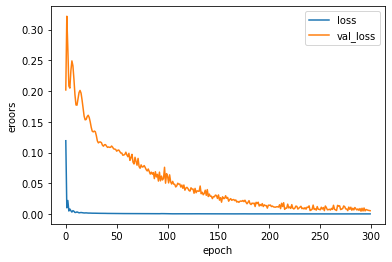

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('eroors')
plt.legend()
plt.show()

89/89 [==============================] - 1s 8ms/sample - loss: 8.1858e-04
0.0008185766728887899
453.16710205277514


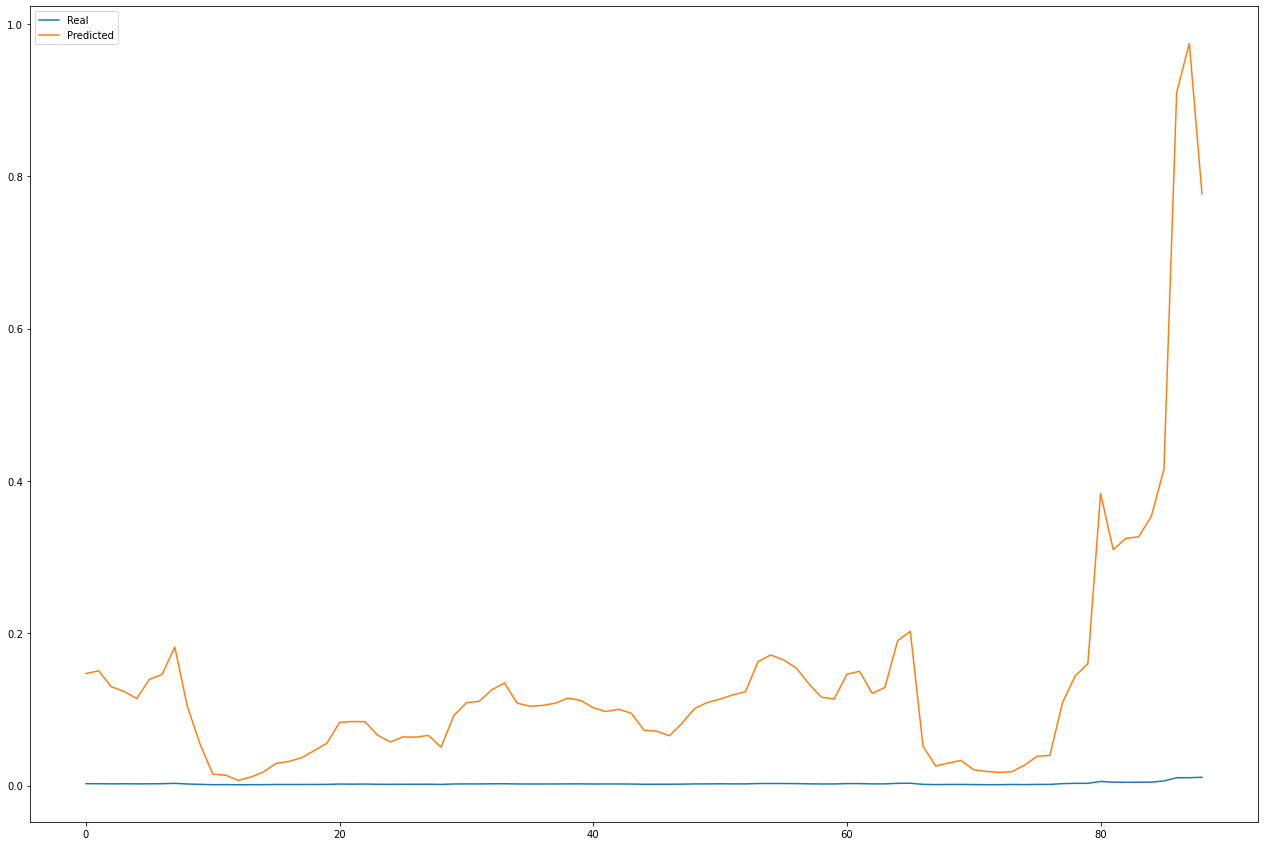

In [27]:
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)
y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_scaler.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_scaler.inverse_transform(y_predicted)
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

plt.gcf().set_size_inches(22, 15, forward=True)
start = 0
end = -1
real = plt.plot(unscaled_y_test, label='real')
pred = plt.plot(y_test_predicted, label='predicted')
plt.legend(['Real', 'Predicted'])
plt.show()



In [19]:
model.save("models\keep_predit_lstm.h5")


In [ ]:
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)
y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_scaler.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_scaler.inverse_transform(y_predicted)
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

plt.gcf().set_size_inches(22, 15, forward=True)
start = 0
end = -1
real = plt.plot(unscaled_y_test, label='real')
pred = plt.plot(y_test_predicted, label='predicted')
plt.legend(['Real', 'Predicted'])
plt.show()



history_points = 10
df = df.reset_index(drop=True)
data = df.copy()
del data['time']
data = data.reset_index()
data = data.drop('index', axis=1)
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)
ohlcv_histories_normalised = np.array([data_normalised[i: i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.array([data_normalised[:,1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
next_day_open_values = np.array([data.loc[:, "close_b"][i + history_points].copy() for i in range(len(data) - history_points)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)
model = load_model("models\keep_predit_lstm.h5")
save = pd.DataFrame(columns=['time', 'lstm_predict'])